# 使用 PyTorch 实现手写数字识别

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim

print(torch.__version__)

1.9.0+cu102


# 定义超参数，方便后面使用

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# 导入数据
直接下载很慢，所以我们选择提前下载好并放置在相应目录，并设置 `download=False`

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/mnist/', train=True, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/mnist/', train=False, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True
)

C:\Users\xvyn\anaconda3\envs\handwriting\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


查看数据是否导入成功

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets.shape)
print(example_data.shape)

torch.Size([1000])
torch.Size([1000, 1, 28, 28])


选取一些图片进行展示

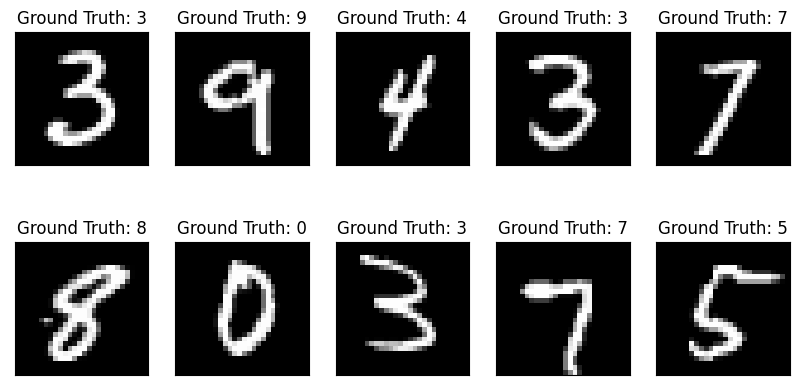

In [5]:
import random
offset = random.randint(0, 990)

fig = plt.figure(figsize=(10, 5), dpi=100)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example_data[i + offset][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i + offset]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# 构建网络

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(5, 5))
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # 在调用 dropout 函数时，最好显式指定 kernel_size 和 stride，以免混淆
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=(2, 2), stride=2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# 检查网络的结构

In [9]:
!pip install torchsummary

In [10]:
print(network)
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----

C:\Users\xvyn\anaconda3\envs\handwriting\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-7-33fa178f8d61>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# 定义训练和测试函数

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [13]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

# 开始训练

In [14]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-7-33fa178f8d61>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\xvyn\anaconda3\envs\handwriting\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322170
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.289583
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.248415
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299365
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.269007
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.221427
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.226077
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.085956
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.026373
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.040608
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.717071
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.816669
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.647458
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.726761
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.378387
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.454929
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.323796
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.170728
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.302907
Train Epoch: 1 [12160/6

# 打印历史 Loss，绘制成图

[0, 60000, 120000, 180000]
[2.309582421875, 0.19407357635498046, 0.11960812454223632, 0.09580788192749023]


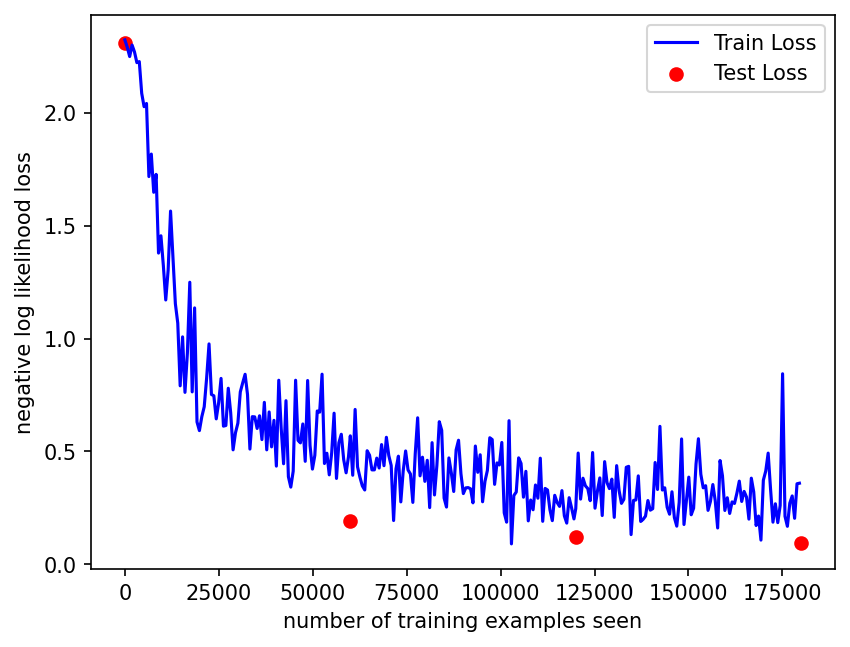

In [15]:
print(test_counter)
print(test_losses)

fig = plt.figure(dpi=150)
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# 测试

In [16]:
with torch.no_grad():
    output = network(example_data)

<ipython-input-7-33fa178f8d61>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


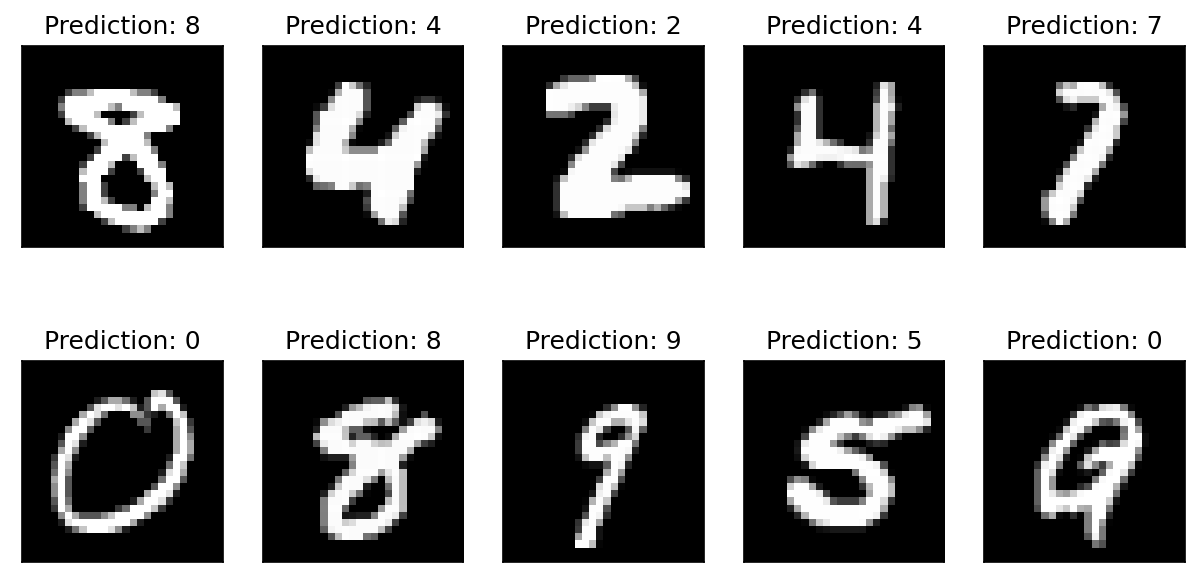

In [17]:
offset = random.randint(0, 990)
fig = plt.figure(figsize=(10, 5), dpi=150)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example_data[i + offset][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i + offset].item()))
    plt.xticks([])
    plt.yticks([])
fig

# 继续训练

In [18]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [19]:
network_state_dict = torch.load('results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [20]:
for i in range(4, 9):
    test_counter.append(i * len(train_loader.dataset))
    train(i)
    test()

<ipython-input-7-33fa178f8d61>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.406487
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.215435
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.342377
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.288813
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.389465
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.217996
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.235051
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.273064
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.212089
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.192088
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.373529
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.365777
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.154129
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.171889
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.349929
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.326404
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.226820
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.320976
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.264583
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.437664
Train Epoch: 4 [12800/60000 (

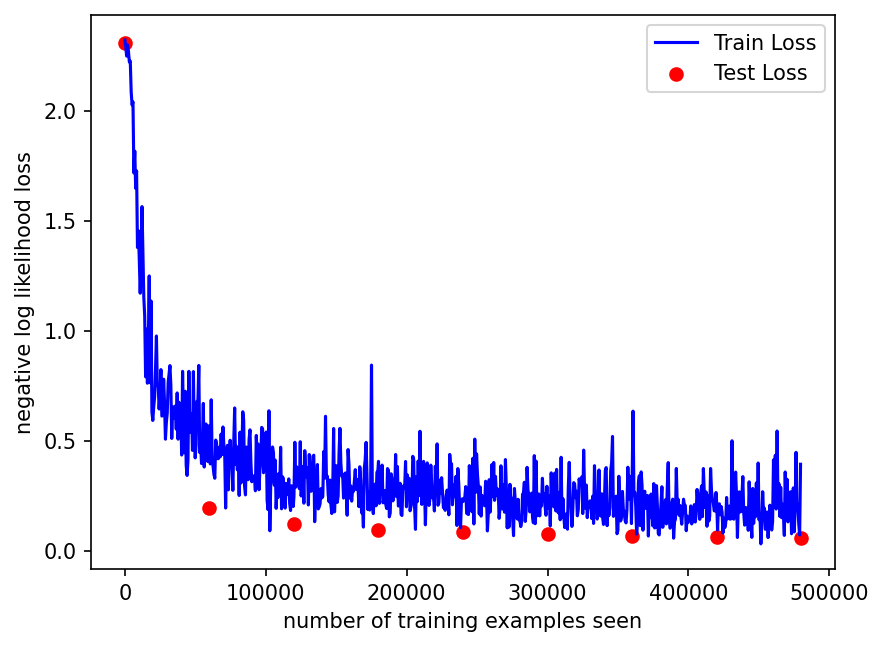

In [21]:
fig = plt.figure(dpi=150)
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# 参考文献
1. https://nextjournal.com/gkoehler/pytorch-mnist#continued-training-from-checkpoints
2. https://ravivaishnav20.medium.com/handwritten-digit-recognition-using-pytorch-get-99-5-accuracy-in-20-k-parameters-bcb0a2bdfa09
3. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html